--- 🏥 A病院の学習用データをアップロードしてください ---
1. 採血ログファイル


Saving final_combined_log.csv to final_combined_log.csv

2. 外来患者数ファイル


Saving 外来患者数.csv to 外来患者数.csv

3. 気象データ


Saving 岐阜気象データ.csv to 岐阜気象データ.csv

--- データ処理を開始します ---
✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: 164466
✅ データ分割完了。学習データ: 246件, 検証データ: 161件

--- XGBoostモデルを構築します (10-fold CV) ---
✅ モデル学習完了。最適パラメータ: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

--- 検証データでモデルの性能を評価します ---
📈 評価指標: RMSE=39.58, R2スコア=0.612

--- SHAPでモデルの解釈を可視化します ---


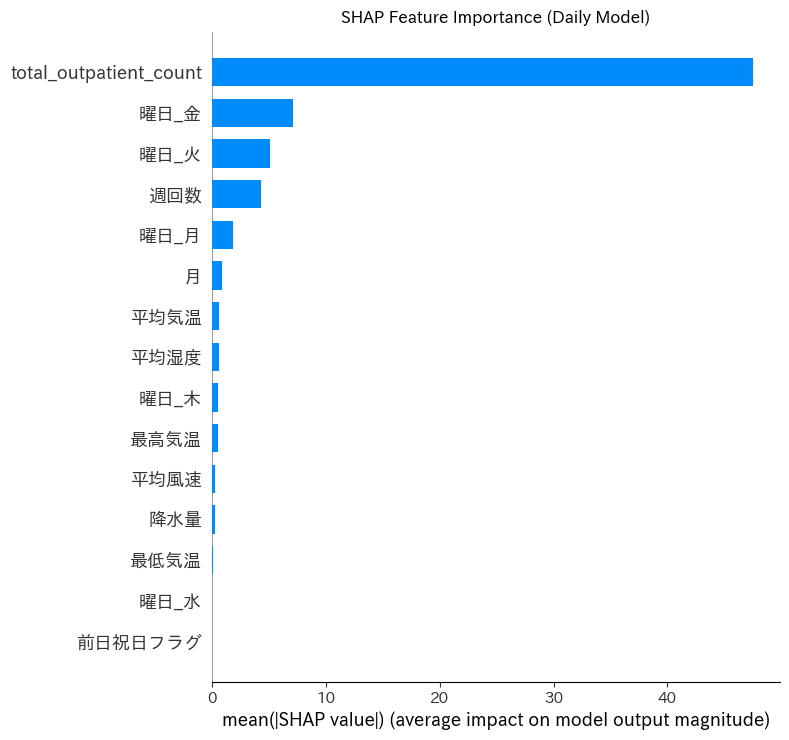


✅ A病院用のファイルを3つ保存しました。
   - model_A_daily.json (B病院へ提供)
   - best_params_A_daily.json (B病院へ提供)
   - model_A_daily_scaler.joblib (UIで使用)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title 🏥 A病院 日次予測モデル 学習スクリプト (重複除去・構文修正版)
# =================================================================
# 1. ライブラリのインストール
# =================================================================
!pip -q install japanize-matplotlib jpholiday scikit-learn xgboost shap

# =================================================================
# 2. ライブラリのインポート
# =================================================================
import pandas as pd
import numpy as np
import jpholiday
from datetime import date, timedelta
import io
import json
import joblib
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import warnings
warnings.filterwarnings('ignore')
import shap
import matplotlib.pyplot as plt
import japanize_matplotlib

# =================================================================
# 3. A病院データのアップロード
# =================================================================
print("--- 🏥 A病院の学習用データをアップロードしてください ---")
print("1. 採血ログファイル")
uploaded_log = files.upload()
print("\n2. 外来患者数ファイル")
uploaded_patients = files.upload()
print("\n3. 気象データ")
uploaded_weather = files.upload()

# =================================================================
# 4. モデル構築パイプライン
# =================================================================
try:
    # --- 4a. データ処理 ---
    print("\n--- データ処理を開始します ---")
    start_dt, end_dt = date(2024, 1, 1), date(2026, 12, 31)
    all_dates_list = [start_dt + timedelta(days=d) for d in range((end_dt - start_dt).days + 1)]
    calendar_features = pd.DataFrame({'date': pd.to_datetime(all_dates_list)})
    is_holiday_series = calendar_features['date'].apply(
        lambda x: jpholiday.is_holiday(x) or x.weekday() >= 5 or \
                    (x.month == 12 and x.day >= 29) or (x.month == 1 and x.day <= 3)
    )
    calendar_features['is_holiday'] = is_holiday_series
    calendar_features['月'] = calendar_features['date'].dt.month
    weekday_map = {0: '月', 1: '火', 2: '水', 3: '木', 4: '金', 5: '土', 6: '日'}
    calendar_features['曜日'] = calendar_features['date'].dt.dayofweek.map(weekday_map)
    calendar_features['週回数'] = (calendar_features['date'].dt.day - 1) // 7 + 1
    calendar_features['前日祝日フラグ'] = calendar_features['is_holiday'].shift(1).fillna(False)

    log_df = pd.read_csv(io.BytesIO(next(iter(uploaded_log.values()))), encoding='shift-jis')

    log_df = log_df[log_df['処理'] == '終了'].copy()
    print(f"✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: {len(log_df)}")

    log_df['実施日'] = pd.to_datetime(log_df['実施日'], format='%y/%m/%d', errors='coerce')
    daily_blood_patients = log_df.groupby('実施日').size().reset_index(name='blood_patient_count')

    total_patients_df = pd.read_csv(io.BytesIO(next(iter(uploaded_patients.values()))), encoding='utf-8-sig', thousands=',')
    total_patients_df['date'] = pd.to_datetime(total_patients_df['date'], errors='coerce')

    weather_raw_df = pd.read_csv(io.BytesIO(next(iter(uploaded_weather.values()))), encoding='shift-jis', header=None, skiprows=3)
    header = weather_raw_df.iloc[0]
    weather_df = weather_raw_df.iloc[3:].reset_index(drop=True)
    weather_df.columns = header

    df_selected = weather_df.iloc[:, [0, 1, 5, 8, 11, 14, 20, 23]].copy()
    df_selected.columns = ['date', '降水量', '天気概況', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']

    df_selected['雨フラグ'] = df_selected['天気概況'].str.contains('雨', na=False).astype(int)
    df_selected['雪フラグ'] = df_selected['天気概況'].str.contains('雪', na=False).astype(int)
    weather_features = df_selected.drop(columns=['天気概況'])

    weather_features['date'] = pd.to_datetime(weather_features['date'], errors='coerce')
    numeric_cols = ['降水量', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']
    for col in numeric_cols:
        weather_features[col] = pd.to_numeric(weather_features[col], errors='coerce')
        weather_features[col].fillna(weather_features[col].mean(), inplace=True)

    df = pd.merge(calendar_features, total_patients_df, on='date', how='left')
    df = pd.merge(df, daily_blood_patients, left_on='date', right_on='実施日', how='left')
    df = pd.merge(df, weather_features, on='date', how='left')
    df.dropna(subset=['blood_patient_count', 'total_outpatient_count'], inplace=True)

    # --- 4b. 学習・検証データ分割 ---
    df_encoded = pd.get_dummies(df.drop(columns=['is_holiday', '実施日'], errors='ignore'), columns=['曜日'], drop_first=True)
    df_encoded['前日祝日フラグ'] = df_encoded['前日祝日フラグ'].astype(int)
    train_df = df_encoded[df_encoded['date'].dt.year == 2024].copy()
    val_df = df_encoded[(df_encoded['date'].dt.year == 2025) & (df_encoded['date'].dt.month <= 8)].copy()

    features = [col for col in train_df.columns if col not in ['date', 'blood_patient_count']]
    X_train, y_train = train_df[features], train_df['blood_patient_count']
    X_val, y_val = val_df[features], val_df['blood_patient_count']
    print(f"✅ データ分割完了。学習データ: {len(X_train)}件, 検証データ: {len(X_val)}件")

    # --- 4c. XGBoostモデル学習と最適化 ---
    print("\n--- XGBoostモデルを構築します (10-fold CV) ---")
    param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.05]}
    grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                               param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_xgb_model = grid_search.best_estimator_
    print(f"✅ モデル学習完了。最適パラメータ: {grid_search.best_params_}")

    # --- 4d. モデル性能評価 ---
    print("\n--- 検証データでモデルの性能を評価します ---")
    y_pred = best_xgb_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"📈 評価指標: RMSE={rmse:.2f}, R2スコア={r2:.3f}")

    # --- 4e. SHAPによるモデルの可視化 ---
    print("\n--- SHAPでモデルの解釈を可視化します ---")
    explainer = shap.TreeExplainer(best_xgb_model)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=15, show=False)
    plt.title('SHAP Feature Importance (Daily Model)')
    plt.tight_layout()
    plt.show()

    # --- 4f. 成果物の保存 ---
    best_params = grid_search.best_params_
    scaler = StandardScaler().fit(X_train)

    joblib.dump(scaler, 'model_A_daily_scaler.joblib')
    best_xgb_model.save_model('model_A_daily.json')
    # ★★★ 修正箇所 ★★★
    with open('best_params_A_daily.json', 'w') as f:
        json.dump(best_params, f)

    print("\n✅ A病院用のファイルを3つ保存しました。")
    print("   - model_A_daily.json (B病院へ提供)")
    print("   - best_params_A_daily.json (B病院へ提供)")
    print("   - model_A_daily_scaler.joblib (UIで使用)")

    files.download('model_A_daily.json')
    files.download('best_params_A_daily.json')
    files.download('model_A_daily_scaler.joblib')

except Exception as e:
    print(f"\n予期せぬエラーが発生しました: {e}")

--- 🏥 A病院の学習用データをアップロードしてください ---
1. 採血ログファイル (「受信」「処理」列を含む)


Saving final_combined_log.csv to final_combined_log (1).csv

2. 外来患者数ファイル


Saving 外来患者数.csv to 外来患者数 (1).csv

3. 気象データ


Saving 岐阜気象データ.csv to 岐阜気象データ (1).csv

--- データ読み込みと初期処理を開始します ---
✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: 164466

--- ログデータを30分単位の時系列データに変換します ---

--- 時間帯予測用の特徴量を作成します ---
✅ データ分割完了。学習データ: 7623件, 検証データ: 5057件

--- XGBoost時系列モデルを学習します ---
✅ モデル学習完了。

--- 検証データでモデルの性能を評価します ---
📈 評価指標 (時間帯別モデル): RMSE: 約 4.97 人/30分, R2スコア: 0.952

--- SHAPでモデルの解釈を可視化します ---


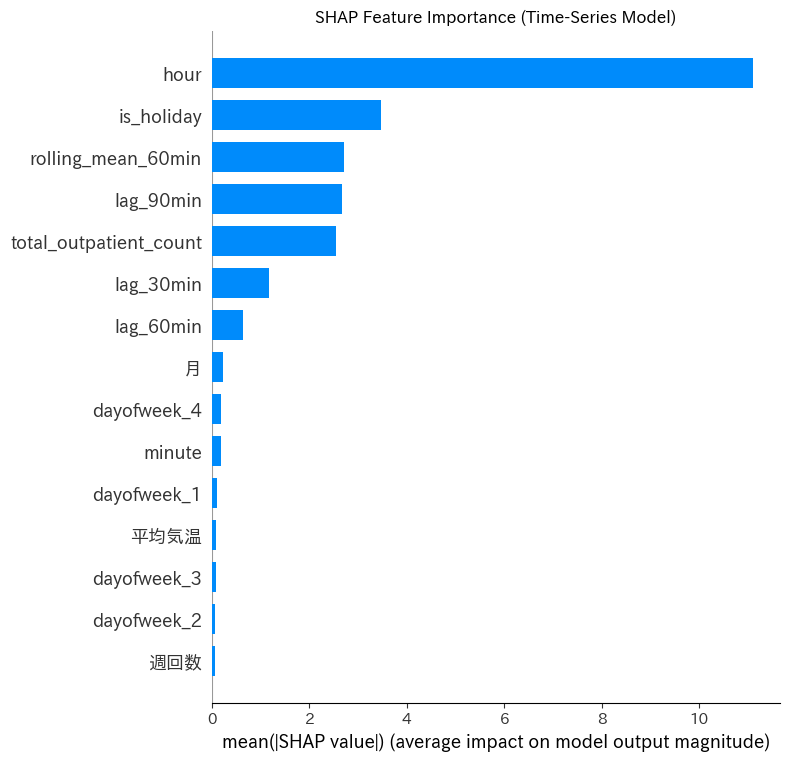


✅ A病院用の時間帯予測モデルとカラムリストを保存しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title 🏥 A病院 時間帯別予測モデル 学習スクリプト (重複除去・安定版)
# =================================================================
# 1. ライブラリのインストール
# =================================================================
!pip -q install japanize-matplotlib jpholiday scikit-learn xgboost shap

# =================================================================
# 2. ライブラリのインポート
# =================================================================
import pandas as pd
import numpy as np
import jpholiday
from datetime import date, timedelta
import io
import json
import shap
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# =================================================================
# 3. A病院データのアップロード
# =================================================================
print("--- 🏥 A病院の学習用データをアップロードしてください ---")
print("1. 採血ログファイル (「受信」「処理」列を含む)")
uploaded_log = files.upload()
print("\n2. 外来患者数ファイル")
uploaded_patients = files.upload()
print("\n3. 気象データ")
uploaded_weather = files.upload()

# =================================================================
# 4. モデル構築パイプライン
# =================================================================
try:
    # --- 4a. 全データの読み込み ---
    print("\n--- データ読み込みと初期処理を開始します ---")
    log_df = pd.read_csv(io.BytesIO(next(iter(uploaded_log.values()))), encoding='shift-jis')
    total_patients_df = pd.read_csv(io.BytesIO(next(iter(uploaded_patients.values()))), encoding='utf-8-sig', thousands=',')
    weather_raw_df = pd.read_csv(io.BytesIO(next(iter(uploaded_weather.values()))), encoding='shift-jis', header=None, skiprows=3)

    # 「処理」列が「終了」の行のみにフィルタリング
    log_df = log_df[log_df['処理'] == '終了'].copy()
    print(f"✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: {len(log_df)}")

    # --- 4b. 時系列データの作成 ---
    print("\n--- ログデータを30分単位の時系列データに変換します ---")
    log_df['time'] = pd.to_datetime(log_df['受信'], errors='coerce')
    log_df.dropna(subset=['time'], inplace=True)
    log_df.set_index('time', inplace=True)
    patient_count_by_slot = log_df.resample('30T').size().rename('patient_count_slot')
    patient_count_by_slot = patient_count_by_slot.between_time('08:00', '18:00')
    df_ts = patient_count_by_slot.to_frame()

    # --- 4c. 特徴量エンジニアリング ---
    print("\n--- 時間帯予測用の特徴量を作成します ---")

    # 時間ベース特徴量
    df_ts['hour'] = df_ts.index.hour
    df_ts['minute'] = df_ts.index.minute
    df_ts['dayofweek'] = df_ts.index.dayofweek
    df_ts['date'] = pd.to_datetime(df_ts.index.date)

    # 「一日の始まり」フラグ
    df_ts['is_first_slot'] = ((df_ts['hour'] == 8) & (df_ts['minute'] == 0)).astype(int)
    df_ts['is_second_slot'] = ((df_ts['hour'] == 8) & (df_ts['minute'] == 30)).astype(int)

    # 日次カレンダー特徴量
    daily_dates = pd.DataFrame({'date': pd.to_datetime(df_ts['date'].unique())})
    daily_dates['is_holiday_daily'] = daily_dates['date'].apply(
        lambda x: jpholiday.is_holiday(x) or x.weekday() >= 5 or \
                    (x.month == 12 and x.day >= 29) or (x.month == 1 and x.day <= 3)
    )
    daily_dates['月'] = daily_dates['date'].dt.month
    daily_dates['週回数'] = (daily_dates['date'].dt.day - 1) // 7 + 1
    daily_dates['前日祝日フラグ'] = daily_dates['is_holiday_daily'].shift(1).fillna(False).astype(int)

    # 天気と外来患者数データの前処理とマージ
    total_patients_df['date'] = pd.to_datetime(total_patients_df['date'], errors='coerce')
    header_w = weather_raw_df.iloc[0]
    weather_df = weather_raw_df.iloc[3:].reset_index(drop=True); weather_df.columns = header_w
    weather_features = weather_df.iloc[:, [0, 1, 5, 8, 11, 14, 20, 23]].copy()
    weather_features.columns = ['date', '降水量', '天気概況', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']
    weather_features['date'] = pd.to_datetime(weather_features['date'], errors='coerce')
    numeric_cols = ['降水量', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']
    for col in numeric_cols:
        weather_features[col] = pd.to_numeric(weather_features[col], errors='coerce')
        weather_features[col].fillna(weather_features[col].mean(), inplace=True)
    weather_features['雨フラグ'] = weather_features['天気概況'].str.contains('雨', na=False).astype(int)
    weather_features['雪フラグ'] = weather_features['天気概況'].str.contains('雪', na=False).astype(int)
    weather_features['天気カテゴリ'] = weather_features['天気概況'].str[0]

    df_ts = pd.merge(df_ts, daily_dates, on='date', how='left')
    df_ts = pd.merge(df_ts, total_patients_df, on='date', how='left')
    df_ts = pd.merge(df_ts, weather_features.drop(columns=['天気概況']), on='date', how='left')

    df_ts = pd.get_dummies(df_ts, columns=['dayofweek', '天気カテゴリ'], drop_first=True)

    # ラグ特徴量
    df_ts['lag_30min'] = df_ts['patient_count_slot'].shift(1)
    df_ts['lag_60min'] = df_ts['patient_count_slot'].shift(2)
    df_ts['lag_90min'] = df_ts['patient_count_slot'].shift(3)
    df_ts['rolling_mean_60min'] = df_ts['patient_count_slot'].shift(1).rolling(window=2).mean()

    df_ts.rename(columns={'is_holiday_daily': 'is_holiday'}, inplace=True)
    df_ts.fillna(0, inplace=True)

    # --- 4d. 学習・検証データ分割 ---
    train_df = df_ts[df_ts['date'].dt.year == 2024].copy()
    val_df = df_ts[(df_ts['date'].dt.year == 2025) & (df_ts['date'].dt.month <= 8)].copy()
    train_df.drop(columns=['date'], inplace=True)
    val_df.drop(columns=['date'], inplace=True)

    features = [col for col in train_df.columns if col != 'patient_count_slot']
    X_train, y_train = train_df[features], train_df['patient_count_slot']
    X_val, y_val = val_df[features], val_df['patient_count_slot']
    print(f"✅ データ分割完了。学習データ: {len(X_train)}件, 検証データ: {len(X_val)}件")

    # --- 4e. XGBoostモデルの学習 ---
    print("\n--- XGBoost時系列モデルを学習します ---")
    model = xgb.XGBRegressor(
        objective='reg:squarederror', n_estimators=1000, learning_rate=0.01,
        max_depth=6, early_stopping_rounds=50, random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    print("✅ モデル学習完了。")

    # --- 4f. モデル性能の評価 ---
    print("\n--- 検証データでモデルの性能を評価します ---")
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"📈 評価指標 (時間帯別モデル): RMSE: 約 {rmse:.2f} 人/30分, R2スコア: {r2:.3f}")

    # --- 4g. SHAPによるモデルの可視化 ---
    print("\n--- SHAPでモデルの解釈を可視化します ---")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=15, show=False)
    plt.title('SHAP Feature Importance (Time-Series Model)')
    plt.show()

    # --- 4h. 成果物の保存 ---
    model.save_model('model_A_timeseries.json')
    with open('columns_A_timeseries.json', 'w') as f:
        json.dump(list(X_train.columns), f)

    print("\n✅ A病院用の時間帯予測モデルとカラムリストを保存しました。")
    files.download('model_A_timeseries.json')
    files.download('columns_A_timeseries.json')

except Exception as e:
    print(f"\n予期せぬエラーが発生しました: {e}")

In [ ]:
#@title 🏥 A病院 待ち人数・待ち時間 同時予測モデル 学習スクリプト (最終修正版)
# =================================================================
# 1. ライブラリのインストール
# =================================================================
!pip -q install japanize-matplotlib jpholiday scikit-learn xgboost shap

# =================================================================
# 2. ライブラリのインポート
# =================================================================
import pandas as pd
import numpy as np
import jpholiday
from datetime import date, timedelta
import io
import json
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.metrics import mean_squared_error, r2_score
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# =================================================================
# 3. A病院データのアップロード
# =================================================================
print("--- 🏥 A病院の学習用データをアップロードしてください ---")
print("1. 採血ログファイル (「受信」「指示書」「処理」列を含む)")
uploaded_log = files.upload()
print("\n2. 外来患者数ファイル")
uploaded_patients = files.upload()
print("\n3. 気象データ")
uploaded_weather = files.upload()

# =================================================================
# 4. モデル構築パイプライン
# =================================================================
try:
    # --- 4a. 全データの読み込みと準備 ---
    print("\n--- データ読み込みと初期処理を開始します ---")
    log_filename = list(uploaded_log.keys())[0]
    patients_filename = list(uploaded_patients.keys())[0]
    weather_filename = list(uploaded_weather.keys())[0]

    log_df = pd.read_csv(io.BytesIO(uploaded_log[log_filename]), encoding='shift-jis')
    total_patients_df = pd.read_csv(io.BytesIO(uploaded_patients[patients_filename]), encoding='utf-8-sig', thousands=',')
    weather_raw_df = pd.read_csv(io.BytesIO(uploaded_weather[weather_filename]), encoding='shift-jis', header=None, skiprows=3)

    log_df = log_df[log_df['処理'] == '終了'].copy()
    print(f"✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: {len(log_df)}")

    # --- 4b. 待ち時間と各イベント時間の算出 ---
    log_df['reception_time'] = pd.to_datetime(log_df['受信'], errors='coerce')
    log_df['call_time'] = pd.to_datetime(log_df['指示書'], errors='coerce')
    log_df.dropna(subset=['reception_time', 'call_time'], inplace=True)

    log_df['wait_minutes'] = (log_df['call_time'] - log_df['reception_time']).dt.total_seconds() / 60
    log_df = log_df[(log_df['wait_minutes'] >= 0) & (log_df['wait_minutes'] <= 180)]

    # --- 4c. 30分単位でのデータ集計 ---
    print("\n--- データを30分単位に集計します ---")
    avg_wait = log_df.set_index('call_time')['wait_minutes'].resample('30T').mean().to_frame(name='avg_wait_minutes')
    receptions = log_df.set_index('reception_time').resample('30T').size().to_frame(name='reception_count')
    calls = log_df.set_index('call_time').resample('30T').size().to_frame(name='call_count')

    df_30min = pd.concat([avg_wait, receptions, calls], axis=1).fillna(0)
    df_30min = df_30min.between_time('08:00', '18:00')

    # --- 4d. 特徴量エンジニアリング ---
    print("\n--- 予測用の特徴量を作成します ---")

    # ステップ 1: マージの前に、DatetimeIndexから時間特徴量を先に作成
    df_30min['hour'] = df_30min.index.hour
    df_30min['minute'] = df_30min.index.minute
    df_30min['dayofweek'] = df_30min.index.dayofweek
    df_30min['date'] = pd.to_datetime(df_30min.index.date)

    # ステップ 2: 日次特徴量の準備
    daily_dates = pd.DataFrame({'date': pd.to_datetime(df_30min['date'].unique())})
    daily_dates['is_holiday'] = daily_dates['date'].apply(
        lambda x: jpholiday.is_holiday(x) or x.weekday() >= 5 or \
                    (x.month == 12 and x.day >= 29) or (x.month == 1 and x.day <= 3)
    )
    daily_dates['月'] = daily_dates['date'].dt.month
    daily_dates['週回数'] = (daily_dates['date'].dt.day - 1) // 7 + 1
    daily_dates['前日祝日フラグ'] = daily_dates['is_holiday'].shift(1).fillna(False).astype(int)

    total_patients_df['date'] = pd.to_datetime(total_patients_df['date'], errors='coerce')
    header_w = weather_raw_df.iloc[0]
    weather_df = weather_raw_df.iloc[3:].reset_index(drop=True); weather_df.columns = header_w
    weather_features = weather_df.iloc[:, [0, 1, 5, 8, 11, 14, 20, 23]].copy()
    weather_features.columns = ['date', '降水量', '天気概況', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']
    weather_features['date'] = pd.to_datetime(weather_features['date'], errors='coerce')
    numeric_cols = ['降水量', '平均気温', '最高気温', '最低気温', '平均湿度', '平均風速']
    for col in numeric_cols:
        weather_features[col] = pd.to_numeric(weather_features[col], errors='coerce')
        weather_features[col].fillna(weather_features[col].mean(), inplace=True)
    weather_features['雨フラグ'] = weather_features['天気概況'].str.contains('雨', na=False).astype(int)
    weather_features['雪フラグ'] = weather_features['天気概況'].str.contains('雪', na=False).astype(int)
    weather_features['天気カテゴリ'] = weather_features['天気概況'].str[0]

    # ステップ 3: 全ての日次特徴量をマージ (ここでIndexがリセットされる)
    df_30min = pd.merge(df_30min, daily_dates, on='date', how='left')
    df_30min = pd.merge(df_30min, total_patients_df, on='date', how='left')
    df_30min = pd.merge(df_30min, weather_features.drop(columns=['天気概況']), on='date', how='left')
    df_30min = pd.get_dummies(df_30min, columns=['dayofweek', '天気カテゴリ'], drop_first=True)

    # ステップ 4: マージ後に待ち人数関連の特徴量を作成
    df_30min['net_flow'] = df_30min['reception_count'] - df_30min['call_count']
    df_30min['queue_size'] = df_30min.groupby('date')['net_flow'].cumsum()
    df_30min['queue_at_start_of_slot'] = df_30min['queue_size'].shift(1).fillna(0)
    day_starts = df_30min['date'] != df_30min['date'].shift(1)
    df_30min.loc[day_starts, 'queue_at_start_of_slot'] = 0

    df_30min.fillna(0, inplace=True)
    df_30min['is_holiday'] = df_30min['is_holiday'].astype(int)

    # --- 4e. 学習・検証データ分割 ---
    train_df = df_30min[df_30min['date'].dt.year == 2024].copy()
    val_df = df_30min[df_30min['date'].dt.year == 2025].copy()

    targets = ['avg_wait_minutes', 'queue_size']
    features = [col for col in train_df.columns if col not in targets + ['call_count', 'net_flow', 'date']]

    X_train, y_train = train_df[features], train_df[targets]
    X_val, y_val = val_df[features], val_df[targets]
    print(f"✅ データ分割完了。学習データ: {len(X_train)}件, 検証データ: {len(X_val)}件")

    # --- 4f. 2つのXGBoostモデルをそれぞれ学習 ---
    print("\n--- 2つの予測モデルを個別に学習します ---")

    model_waittime = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, learning_rate=0.05, max_depth=5)
    model_waittime.fit(X_train, y_train['avg_wait_minutes'])
    print("✅ 平均待ち時間予測モデルの学習が完了しました。")

    model_queue = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, learning_rate=0.05, max_depth=5)
    model_queue.fit(X_train, y_train['queue_size'])
    print("✅ 待ち人数予測モデルの学習が完了しました。")

    # --- 4g. 両モデルの性能評価 ---
    print("\n--- 検証データで両モデルの性能を評価します ---")
    pred_waittime = model_waittime.predict(X_val)
    rmse_wt = np.sqrt(mean_squared_error(y_val['avg_wait_minutes'], pred_waittime))
    r2_wt = r2_score(y_val['avg_wait_minutes'], pred_waittime)
    print(f"📈 待ち時間モデル評価: RMSE: 約 {rmse_wt:.2f} 分, R2スコア: {r2_wt:.3f}")

    pred_queue = model_queue.predict(X_val)
    rmse_q = np.sqrt(mean_squared_error(y_val['queue_size'], pred_queue))
    r2_q = r2_score(y_val['queue_size'], pred_queue)
    print(f"📈 待ち人数モデル評価: RMSE: 約 {rmse_q:.2f} 人, R2スコア: {r2_q:.3f}")

    # --- 4h. 成果物の保存 ---
    model_waittime.save_model('model_A_waittime_30min.json')
    model_queue.save_model('model_A_queue_30min.json')
    with open('columns_A_multi_30min.json', 'w') as f:
        json.dump(features, f)

    print("\n✅ A病院用の待ち時間・待ち人数予測モデル(30分単位)とカラムリストを保存しました。")
    files.download('model_A_waittime_30min.json')
    files.download('model_A_queue_30min.json')
    files.download('columns_A_multi_30min.json')

except Exception as e:
    print(f"\n予期せぬエラーが発生しました: {e}")

--- 🏥 A病院の学習用データをアップロードしてください ---
1. 採血ログファイル (「受信」「指示書」「処理」列を含む)


Saving final_combined_log.csv to final_combined_log (2).csv

2. 外来患者数ファイル


Saving 外来患者数.csv to 外来患者数 (2).csv

3. 気象データ


Saving 岐阜気象データ.csv to 岐阜気象データ (2).csv

--- データ読み込みと初期処理を開始します ---
✅ ログデータを「終了」レコードのみにフィルタリングしました。対象レコード数: 164466

--- データを30分単位に集計します ---

--- 予測用の特徴量を作成します ---
✅ データ分割完了。学習データ: 7623件, 検証データ: 5057件

--- 2つの予測モデルを個別に学習します ---
✅ 平均待ち時間予測モデルの学習が完了しました。
✅ 待ち人数予測モデルの学習が完了しました。

--- 検証データで両モデルの性能を評価します ---
📈 待ち時間モデル評価: RMSE: 約 1.97 分, R2スコア: 0.957
📈 待ち人数モデル評価: RMSE: 約 2.50 人, R2スコア: 0.984

✅ A病院用の待ち時間・待ち人数予測モデル(30分単位)とカラムリストを保存しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# A 病院 予測モデル学習スクリプト：概要サマリー

* * *

## 1. 日次予測モデル
> **目的**: 1 日の**総採血患者数**を予測する。

### ⚙️ 処理フロー
1. **データ準備**: 以下のファイルをアップロード・ロードします。
   - `採血ログファイル` (列: `実施日`, `処理`)
   - `外来患者数ファイル` (列: `date`, `total_outpatient_count`)
   - `気象データ` (列: `年月日`, `降水量`, `天気概況`, `平均気温`, `最高気温`, `最低気温`, `平均湿度`, `平均風速`)
   ログデータは「終了」レコードにフィルタリング後、日毎に集計します。
2. **特徴量**: カレンダー情報 (`is_holiday`, `月`, `曜日`, `週回数`, `前日祝日フラグ`) と気象情報 (`降水量`, `平均気温`, `最高気温`, `最低気温`, `平均湿度`, `平均風速`, `雨フラグ`, `雪フラグ`) を生成・使用します。
3. **モデル学習**: 2024 年の日次データで`XGBoost`モデルを学習。`GridSearchCV`と 10 分割 CV でハイパーパラメータを最適化します。
4. **評価と可視化**: 2025 年データで精度（RMSE, R2）を評価し、`SHAP`で特徴量の重要度を可視化します。
5. **成果物**:
   * `model_A_daily.json` (モデル)
   * `model_A_daily_scaler.joblib` (スケーラー)
   * `best_params_A_daily.json` (最適パラメータ)

* * *

## 2. 時間帯別 受付数予測モデル
> **目的**: 1 日の中の**30 分単位の受付患者数**を予測する。

### ⚙️ 処理フロー
1. **データ準備**: 日次モデルと同じ 3 ファイルをアップロード・ロードします。
   - `採血ログファイル` (列: `受信`, `処理`)
   - `外来患者数ファイル` (列: `date`, `total_outpatient_count`)
   - `気象データ` (列: `年月日`, `降水量`, `天気概況`, `平均気温`, `最高気温`, `最低気温`, `平均湿度`, `平均風速`)
   ログデータは「終了」レコードの「受信」時間を基に 30 分単位で集計します。
2. **特徴量**:
   * **時間ベース**: `hour`, `minute`, `dayofweek`等。
   * **日次**: 日次モデルと同様のカレンダー・気象情報を各時間帯に付与します。
   * **時系列**: `ラグ特徴量`（直前の受付数）、`移動平均`を追加します。
   * **安定化**: `is_first_slot`等のフラグで予測開始時の挙動を安定化します。
3. **モデル学習**: 2024 年の 30 分枠データで`XGBoost`モデルを学習。`Early Stopping`で過学習を防止します。
4. **評価と可視化**: 2025 年データで精度を評価し、`SHAP`で可視化します。
5. **成果物**:
   * `model_A_timeseries.json` (モデル)
   * `columns_A_timeseries.json` (特徴量リスト)

* * *

## 3. 時間帯別 待ち人数・待ち時間予測モデル
> **目的**: 1 日の中の**30 分単位の待ち人数**と**平均待ち時間**を同時に予測する。

### ⚙️ 処理フロー
1. **データ準備**: 日次・受付数モデルと同じ 3 ファイルをアップロード・ロードします。
   - `採血ログファイル` (列: `受信`, `指示書`, `処理`)
   - `外来患者数ファイル` (列: `date`, `total_outpatient_count`)
   - `気象データ` (列: `年月日`, `降水量`, `天気概況`, `平均気温`, `最高気温`, `最低気温`, `平均湿度`, `平均風速`)
2. **目的変数作成**:
   * **平均待ち時間**: 「受信」と「指示書」の時刻差から算出します。
   * **待ち人数**: 「受付数」と「呼出数」の累積差から算出します。
3. **特徴量**: 受付数モデルと同様の特徴量に加え、「時間帯の受付数」、「前の時間帯の待ち人数」など、待ち行列に特化した情報を追加します。
4. **モデル学習**:
   * **2 つのモデル**（待ち時間予測モデル、待ち人数予測モデル）をそれぞれ独立して学習します。
5. **評価**: 2025 年データで 2 つのモデルの精度を個別に評価します。
6. **成果物**:
   * `model_A_waittime_30min.json` (待ち時間モデル)
   * `model_A_queue_30min.json` (待ち人数モデル)
   * `columns_A_multi_30min.json` (共用の特徴量リスト)